In [2]:
import cft
from numpy import fft
import numpy as np
from matplotlib import pyplot as plt

In [3]:
rcol = lambda x: 0.237 - 2.13*x + 26.92*x**2 - 65.5*x**3 + 63.5*x**4 - 22.36*x**5
gcol = lambda x: ((0.572 + 1.524*x - 1.811*x**2)/(1 - 0.291*x + 0.1574*x**2))**2
bcol = lambda x: 1/(1.579 - 4.03*x + 12.92*x**2 - 31.4*x**3 + 48.6*x**4 - 23.36*x**5)

unit = np.linspace(0, 1, 100)
cdict = {
    'red': [(x, rcol(x), rcol(x)) for x in unit],
    'green': [(x, gcol(x), gcol(x)) for x in unit],
    'blue': [(x, bcol(x), bcol(x)) for x in unit],
}
plt.register_cmap('Sunset', data=cdict)

In [4]:
N = 256
L = 15
B = cft.Box(2, N, L)

P0 = cft.Power_law(2)
P1 = cft.Power_law(-1.0)  # * cft.Scale(B, 0.1)
P2 = cft.Power_law(-2)

In [54]:
sigma = 1.0
S = cft.Cutoff(B) * cft.Scale(B, sigma) * cft.Pos([L/2, L/2])
H = cft.make_peak(B, P1, S)

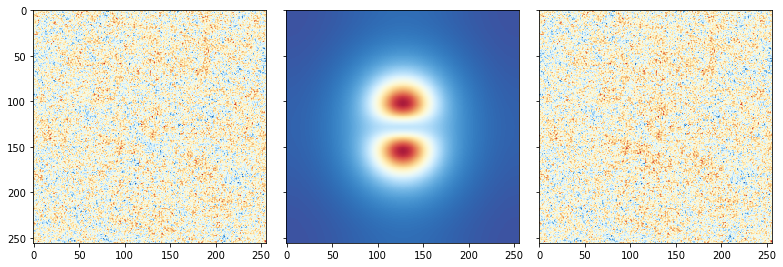

In [55]:
cgrf = cft.CGRF(B, P1, H[0:4])
cgrf.generate_noise(seed=1)
cgrf.set_coefficients(np.r_[1.0, 0, 0, 0.53]*0.7)
A1 = cgrf.triplet()

fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(11, 7))
for ax, a in zip(axes.flat, A1):
    ax.imshow(a, cmap='Sunset')
fig.tight_layout()
plt.show()

In [56]:
cgrf.action(cgrf.g)

1.3261165839074227

In [57]:
pot = cgrf.constrained_field(cft.Potential())

In [58]:
import adhesion

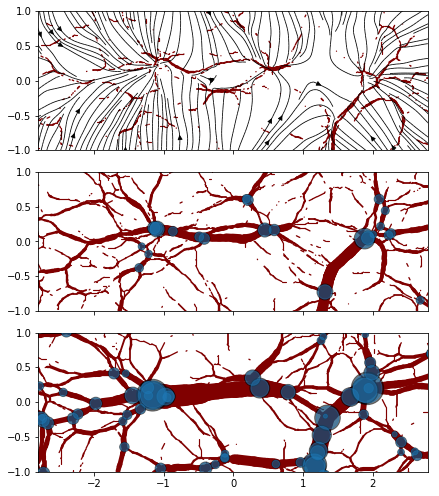

In [68]:
fig, axes = plt.subplots(3, 1, figsize=(6, 7), subplot_kw={'aspect': 1}, sharex=True)
adhs = [adhesion.get_convex_hull(B, pot, t) for t in [1.0, 2.0, 3.0]]
for adh, ax in zip(adhs, axes):
    ch, selection, valid = adh
    adhesion.plot_power_diagram(B, ch, valid, xlim=[-2.8, 2.8], ylim=[-1.0,1.0], ax=ax, point_scale=4, line_scale=10, plot_grid=False)
plot_velocities(B, adhs[0][0], 1.0, adhs[0][1], xlim=[-2.8, 2.8], ylim=[-1.0,1.0], ax=axes[0])
fig.tight_layout()

In [60]:
fig.savefig("filament.pdf", bbox_inches='tight')

In [61]:
def velocities(ch, t, selection=None):
    q = ch.points.copy()
    q[:,2] = (q[:,2] - (q[:,:2]**2).sum(axis=1)) / (-2 * t)
    verts = q[ch.simplices[selection]]
    normals = np.cross(verts[:,1,:] - verts[:,0,:], verts[:,2,:] - verts[:,0,:])
    return normals[:,:2]/normals[:,2:]

In [62]:
ch, selection, valid = adhesion.get_convex_hull(B, pot, 1.0)
vel = velocities(ch, 1.0, selection)
x = adhesion.voronoi_points(ch, selection)

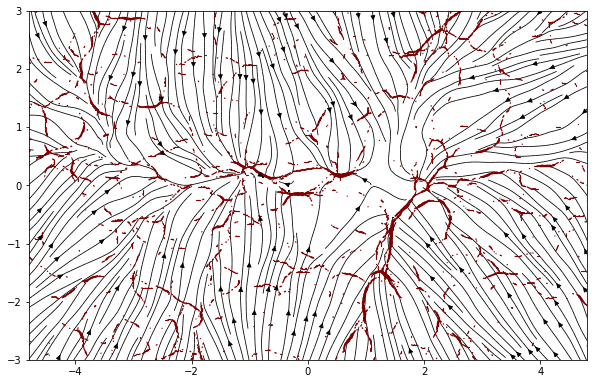

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# ax.quiver(x[:,0], x[:,1], vel[:,0], vel[:,1], scale=50)
plot_velocities(B, ch, 1.0, selection, ax=ax)
adhesion.plot_power_diagram(B, ch, valid, xlim=[-4.8, 4.8], ylim=[-3.0,3.0], ax=ax, point_scale=4, line_scale=10, plot_grid=False)

In [67]:
from adhesion import voronoi_points, delaunay_areas, edges, edge_length, edge_points, delaunay_class
from scipy.interpolate import griddata

def plot_velocities(box, ch, t, selection, xlim=None, ylim=None, ax = None):
    X = voronoi_points(ch, selection)
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    ax.set_aspect('equal')
    if xlim:
        ax.set_xlim(*xlim)
    if ylim:
        ax.set_ylim(*ylim)
    
    sp = X[np.where(
            np.logical_and(
                np.logical_and(X[:,0] > -box.L/3, X[:,0] < box.L/3),
                np.logical_and(X[:,1] > -box.L/3, X[:,1] < box.L/3)))[0]]
    v = velocities(ch, t, selection)
    G = np.indices(box.shape) * box.res - box.L / 2
    v0 = griddata(X, v[:,0], (G[1].flatten(), G[0].flatten())).reshape(box.shape)
    v1 = griddata(X, v[:,1], (G[1].flatten(), G[0].flatten())).reshape(box.shape)
    lw = (v0**2 + v1**2) / 15 + 1
    ax.streamplot(np.arange(box.shape[0]) * box.res - box.L/2,
                  np.arange(box.shape[0]) * box.res - box.L/2,
                  v0, v1,
                  density=10, color='black', zorder=2, linewidth=0.8,
                  #start_points=sp
                 )